# 3D AMRVAC

We create a Magritte model from a snapshot of 3D AMRVAC hydrodynamics simulation.
The hydro model was kindly provided by Jan Bolte.
Currently, the AMRVAC binary files can not yet be used directly to extract the snapshot data.
Hence we use the corresponding `.vtu` files.

## Setup

Import the required functionalty.

In [1]:
import magritte.setup as setup                         # Model setup
import magritte.core  as magritte                      # Core functionality
import magritte.mesher as mesher
import numpy          as np                            # Data structures
import vtk                                             # Reading the model
import warnings                                        # Hide warnings
warnings.filterwarnings('ignore')                      # especially for yt
import yt                                              # 3D plotting
import os

from tqdm                   import tqdm                # Progress bars
from astropy                import constants           # Unit conversions
from vtk.util.numpy_support import vtk_to_numpy        # Converting data
from scipy.spatial          import Delaunay, cKDTree   # Finding neighbors
from yt.funcs               import mylog               # To avoid yt output 
mylog.setLevel(40)                                     # as error messages

Define a working directory (you will have to change this; it must be an **absolute path**).

In [2]:
wdir = "/lhome/thomasc/Magritte-examples/AMRVAC_3D/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
input_file = os.path.join(wdir, 'model_AMRVAC_3D.vtu' )   # AMRVAC snapshot
model_file = os.path.join(wdir, 'model_AMRVAC_3D.hdf5')   # Resulting Magritte model
lamda_file = os.path.join(wdir, 'co.txt'              )   # Line data file

We use a snapshot and data file that can be downloaded with the following links.

In [5]:
input_link = "https://owncloud.ster.kuleuven.be/index.php/s/mqtDyDSMPm2TjmG/download"
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $input_link --output-document $input_file
!wget $lamda_link --output-document $lamda_file

## Extract data

The script below extracts the required data from the snapshot `.vtu` file.

In [7]:
# Create a vtk reader to read the AMRVAC file and extract its contents.
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(input_file)
reader.Update()

# Extract the grid output
grid = reader.GetOutput()

# Extract the number of cells
ncells = grid.GetNumberOfCells() 

# Extract cell data
cellData = grid.GetCellData()
for i in tqdm(range(cellData.GetNumberOfArrays())):
    array = cellData.GetArray(i)
    if (array.GetName() == 'rho'):
        rho = vtk_to_numpy(array)
    if (array.GetName() == 'temperature'):
        tmp = vtk_to_numpy(array)
    if (array.GetName() == 'v1'):
        v_x = vtk_to_numpy(array)
    if (array.GetName() == 'v2'):
        v_y = vtk_to_numpy(array)
    if (array.GetName() == 'v3'):
        v_z = vtk_to_numpy(array)

# Convert rho (total density) to abundances
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

# Convenience arrays
zeros = np.zeros(ncells)
ones  = np.ones (ncells)

# Convert to fractions of the speed of light
velocity = np.array((v_x, v_y, v_z)).transpose() / constants.c.cgs.value

# Define turbulence at 150 m/s
trb = (150.0/constants.c.si.value)**2 * ones

# Extract cell centres as Magritte points
centres = []
for c in tqdm(range(ncells)):
    cell = grid.GetCell(c)
    centre = np.zeros(3)
    for i in range(8):
        centre = centre + np.array(cell.GetPoints().GetPoint(i))
    centre = 0.125 * centre
    centres.append(centre)
centres  = np.array(centres)
centres *= 1.0e-2   # convert [cm] to [m]
position = centres

# We assume that the geometry to be rectangular. We still need to define the boundary however.
# For adaptive mesh refinement models, we put a boundary box around it (to ensure that we have a convex boundary around the model; this is mainly important for imaging the model).

delta_xyz = (np.max(centres, axis=0) - np.min(centres, axis=0))/2.0#half the width in each direction
center_xyz = (np.max(centres, axis=0) + np.min(centres, axis=0))/2.0
xyz_max = center_xyz + 1.001*delta_xyz
xyz_min = center_xyz - 1.001*delta_xyz

# Add a boundary box around the model, putting the boundary points on a regular grid
box = mesher.create_cubic_uniform_hull(xyz_min, xyz_max, order=5)#the boundary box contains 2**order+1 points in each direction.
nbox = len(box)

# Find closest points, in order to extrapolate the values towards the boundary box.
corresp_points = cKDTree(position).query(box)[1]

# Map data of model to box
position_box = box
velocity_box = velocity[corresp_points]
nCO_box      = nCO     [corresp_points]
nH2_box      = nH2     [corresp_points]
tmp_box      = tmp     [corresp_points]
trb_box      = trb     [corresp_points]

#and extend data arrays
nCO = np.concatenate((nCO_box, nCO))
nH2 = np.concatenate((nH2_box, nH2))
zeros = np.concatenate((np.zeros(nbox), zeros))
ones = np.concatenate((np.ones(nbox), ones))
velocity = np.concatenate((velocity_box, velocity), axis=0)
tmp = np.concatenate((tmp_box, tmp))
trb = np.concatenate((trb_box, trb))
position = np.concatenate((box, position), axis=0)


# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(position)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(len(position))]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Compute the indices of the boundary particles of the mesh, extracted from the Delaunay vertices
# Note: technically, we already know the boundary (the constructed box), but as we compute a Delaunay triangulation either way to find the neighbors, we might as well use it to compute the boundary points.
boundary = set([])
for i in tqdm(range(delaunay.neighbors.shape[0])):
    for k in range(4):
        if (delaunay.neighbors[i][k] == -1):
            nk1,nk2,nk3 = (k+1)%4, (k+2)%4, (k+3)%4 
            boundary.add(delaunay.simplices[i][nk1])
            boundary.add(delaunay.simplices[i][nk2])
            boundary.add(delaunay.simplices[i][nk3])

boundary = list(boundary)
boundary = np.array(boundary)

100%|█████████████████████████████| 2141089/2141089 [00:09<00:00, 232837.59it/s]


## Create model

Now all data is read, we can use it to construct a Magritte model.

<div class="alert alert-warning">

Warning

Since we do not aim to do self-consistent non-LTE simulations in these examples, we only consider the first radiative transition of CO (J=1-0). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [8]:
model = magritte.Model ()                              # Create model object

model.parameters.set_model_name         (model_file)   # Magritte model file
model.parameters.set_dimension          (3)            # This is a 3D model
model.parameters.set_npoints            (len(position))       # Number of points
model.parameters.set_nrays              (12)           # Number of rays  
model.parameters.set_nspecs             (5)            # Number of species (min. 5)
model.parameters.set_nlspecs            (1)            # Number of line species
model.parameters.set_nquads             (31)           # Number of quadrature points

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model.parameters.set_nboundary(boundary.shape[0])
# model.geometry.boundary.boundary2point.set(np.arange(boundary.shape[0]))
model.geometry.boundary.boundary2point.set(boundary)

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


## Plot model

Load the data in a `yt` unstructured mesh.

In [9]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis.


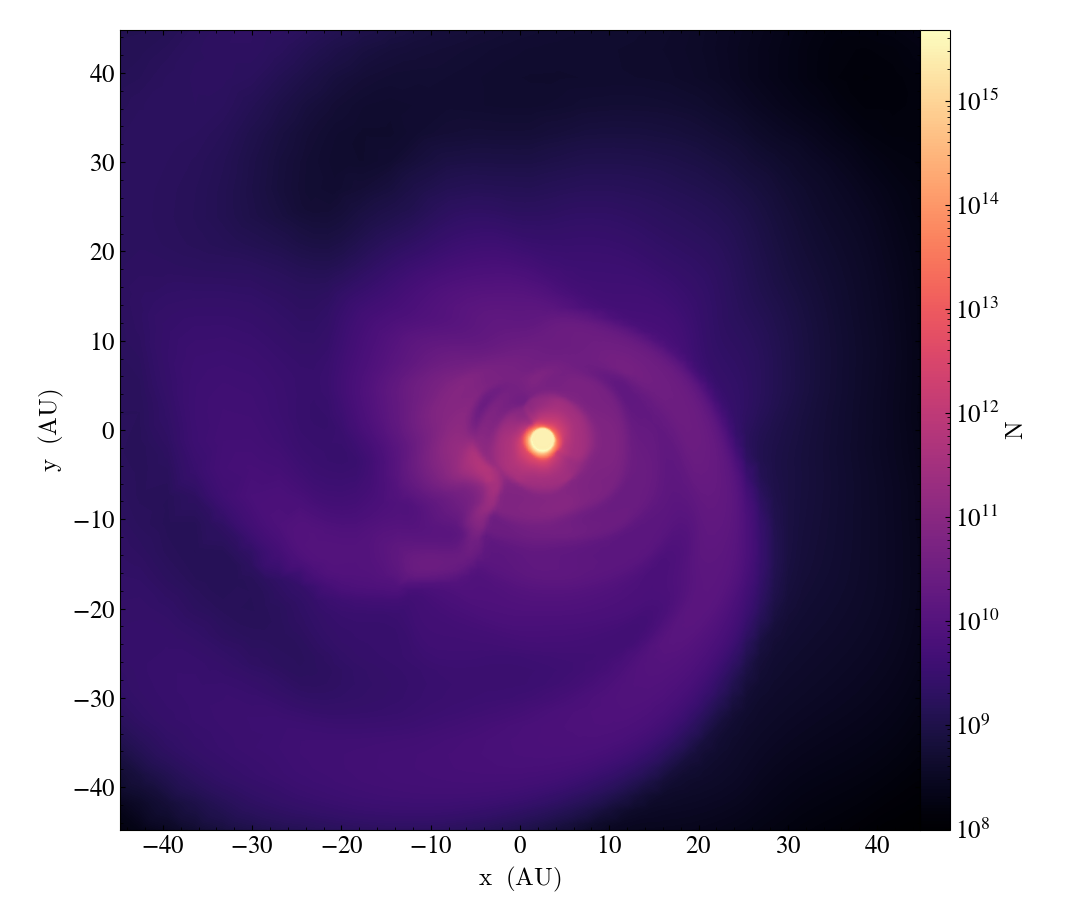

In [10]:
sl = yt.SlicePlot (ds, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)

Show mesh on the plot.


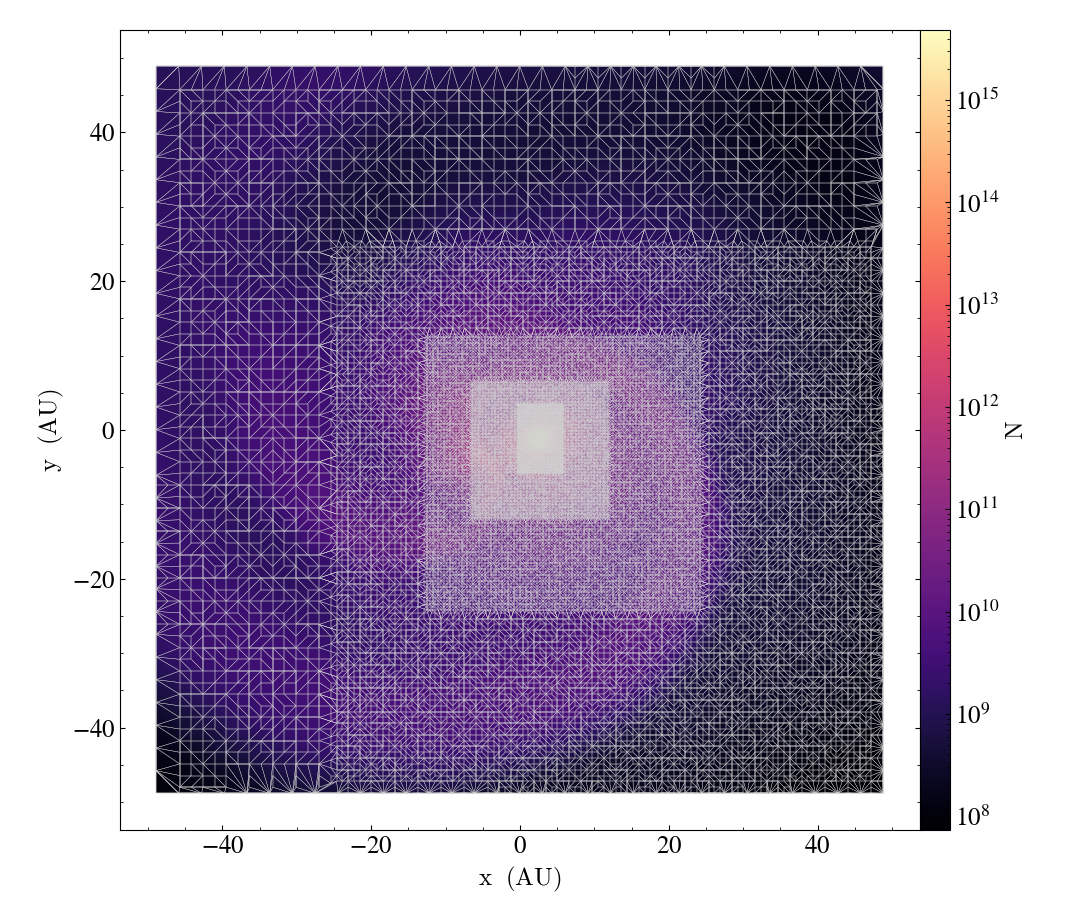

In [11]:
sl = yt.SlicePlot      (ds, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.0)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})

In the [next example](2_reduce_AMRVAC_3D.ipynb) we demonstrate how to reduce this model as in [De Ceuster et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.499.5194D/abstract).